<a href="https://colab.research.google.com/github/utility001/cifar-10/blob/main/cifar_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

+ Use a pretrained model -- MobileNetV2

## Imports

In [1]:
# !pip install --upgrade tf-keras
!pip install tensorflow==2.16.1
!pip install tensorflow_datasets
!pip install keras-tuner
!pip install scikit-learn==1.4.2
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [3]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

## Ingest

In [4]:
# cifar_10 details
tf.keras.datasets.cifar10.load_data?

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [6]:
X_train_full.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    random_state=42,
    test_size=10_000,
    shuffle=True,
    stratify=y_train_full
)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3))

In [9]:
y_train.shape, y_val.shape, y_test.shape

((40000, 1), (10000, 1), (10000, 1))

In [10]:
X_train[0].shape

(32, 32, 3)

In [11]:
X_train[0].min(), X_train[0].max()

(0, 217)

In [12]:
X_train.min(), X_train.max()

(0, 255)

In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
class_names[y_train.flatten()[0]]

'frog'

In [15]:
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()
y_test[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1], dtype=uint8)

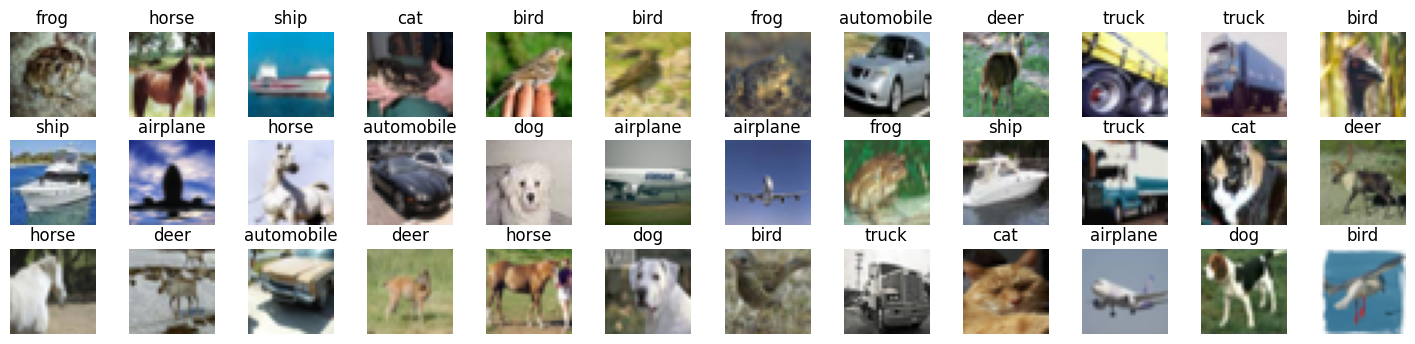

In [16]:
#  Plot a few images from the dataset
plt.figure(figsize=(18, 4))
for idx, image_data in enumerate(X_train[:36]):
    plt.subplot(3, 12, idx + 1)
    plt.imshow(X_train[idx], cmap="binary")
    plt.axis("off");
    plt.title(class_names[y_train[idx]])
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show();

In [17]:
def label_stats(y_train, y_val, y_test):
    # Convert numpy arrays to pandas Series
    y_train_series = pd.Series(y_train)
    y_val_series = pd.Series(y_val)
    y_test_series = pd.Series(y_test)

    # Calculate value counts and percentages for each set
    train_counts = y_train_series.value_counts()
    val_counts = y_val_series.value_counts()
    test_counts = y_test_series.value_counts()

    train_percentages = train_counts / len(y_train_series) * 100
    val_percentages = val_counts / len(y_val_series) * 100
    test_percentages = test_counts / len(y_test_series) * 100

    # Combine counts and percentages into a single DataFrame
    stats_df = pd.DataFrame({
        'Train Counts': train_counts,
        'Train Percentages': train_percentages,
        'Valid Counts': val_counts,
        'Valid Percentages': val_percentages,
        'Test Counts': test_counts,
        'Test Percentages': test_percentages
    })

    # Fill NaN values with 0 (if a label is not present in one of the sets)
    stats_df = stats_df.fillna(0)

    return stats_df

In [18]:
label_stats(y_train, y_val, y_test)

,Train Counts,Train Percentages,Valid Counts,Valid Percentages,Test Counts,Test Percentages
0,4000,10.0,1000,10.0,1000,10.0
1,4000,10.0,1000,10.0,1000,10.0
2,4000,10.0,1000,10.0,1000,10.0
3,4000,10.0,1000,10.0,1000,10.0
4,4000,10.0,1000,10.0,1000,10.0
5,4000,10.0,1000,10.0,1000,10.0
6,4000,10.0,1000,10.0,1000,10.0
7,4000,10.0,1000,10.0,1000,10.0
8,4000,10.0,1000,10.0,1000,10.0
9,4000,10.0,1000,10.0,1000,10.0


## MobileNetV2

+ Load and inspect the pretrained model

In [19]:
# Load MobileNetV2
mnv2 = tf.keras.applications.MobileNetV2(weights="imagenet")

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
len(mnv2.layers)

156

In [21]:
mnv2.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [22]:
# # Examine mobilenet
# tf.keras.utils.plot_model(
#     mnv2,
#     to_file="model_plots/MobileNetV2_architecture.png",
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_activations=True,
#     dpi=60)

## Prepare the data for the task

+ Resizing the images crashed my system. So Convert it into tf.data.datasets format
+ MobileNetV2 demands the image to be [96, 128, 160, 192, 224], resize the input images
+ Apply MobileNetV2 processing steps

In [23]:
# convert to tf.data.datasets
train_set_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train), name="cifar_10_train")
val_set_raw = tf.data.Dataset.from_tensor_slices((X_val, y_val), name="cifar_10_val")
test_set_raw = tf.data.Dataset.from_tensor_slices((X_test, y_test), name="cifar_10_test")

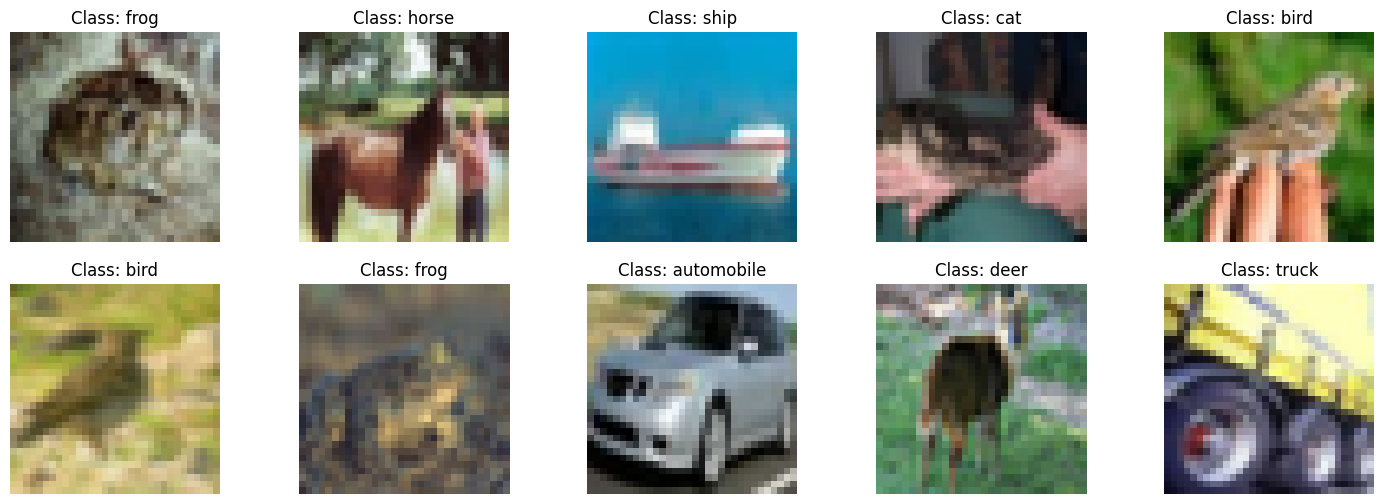

In [24]:
# Some images in the train set

plt.figure(figsize=(18, 6))
index=0
for image, label in train_set_raw.take(10):
  index += 1
  plt.subplot(2, 5, index)
  plt.imshow(image)
  plt.title(f"Class: {class_names[label]}")
  plt.axis("off")
plt.show()

In [25]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=96, width=96, crop_to_aspect_ratio=False),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)
])

In [26]:
train_set = (train_set_raw
             .map(lambda X, y: (preprocess(X), y))
             .shuffle(1000, seed=42)
             .batch(batch_size)
             .prefetch(1)
            )
# train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

In [27]:
# preprocess the validation set
val_set = val_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

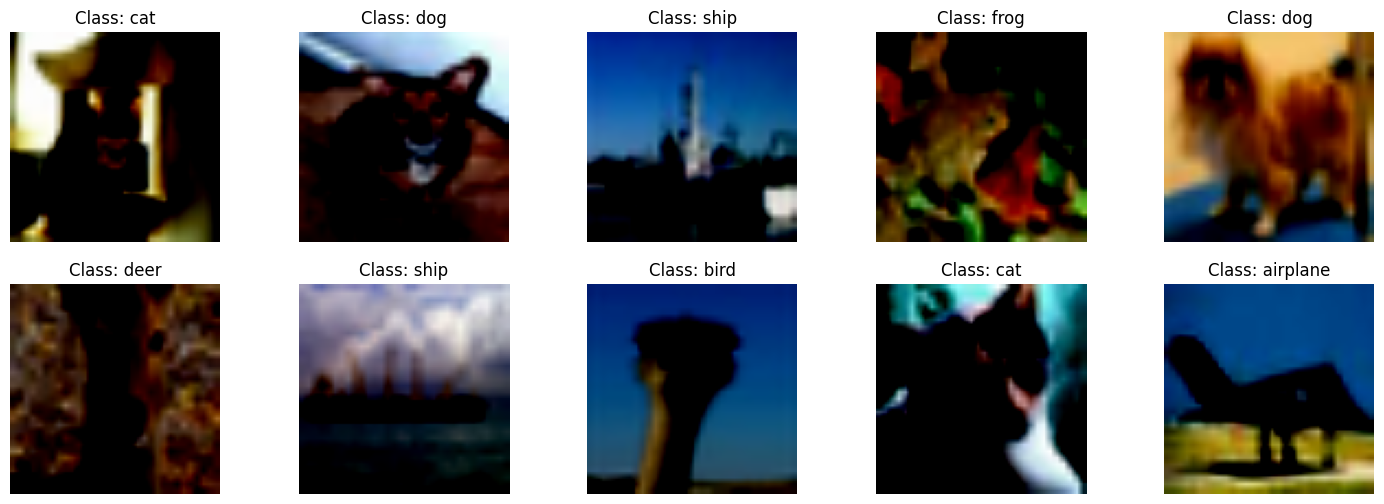

In [28]:
# View the images after resizing and batching

plt.figure(figsize=(18, 6))
index=0
for X_batch, y_batch in train_set.take(10):
  index += 1
  plt.subplot(2, 5, index)
  # print(f"max: {np.max(X_batch[index])}. min: {np.min(X_batch[index])}")
  plt.imshow(np.clip(X_batch[index], 0, 1))
  plt.title(f"Class: {class_names[y_batch[index]]}")
  plt.axis("off")

plt.show();

In [29]:
# Retrieve the first element from the dataset
for image, label in train_set.take(1):
    first_image_size = tf.shape(image[0]).numpy()
    print("First image size:", first_image_size)

First image size: [96 96  3]


In [30]:
_input_shape = list(first_image_size)
_input_shape

[96, 96, 3]

In [31]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=_input_shape,
    include_top=False
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [32]:
# Which layers were removed??
base_model.summary()

Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 48, 48, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 48, 48, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 48, 48, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 48, 48, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 48, 48, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 48, 48, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 48, 48, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 48, 48, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 48, 48, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 49, 49, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 24, 24, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [33]:
# # Examine mobilenet
# tf.keras.utils.plot_model(
#     base_model,
#     to_file="model_plots/MobileNetV2_base.png",
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_activations=True,
#     show_trainable=True,
#     dpi=60)

In [34]:
len(base_model.layers)

154

The last two layers

In [35]:
n_classes = len(class_names)
n_classes

10

In [36]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)


avg = tf.keras.layers.GlobalAveragePooling2D(keepdims=False)(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

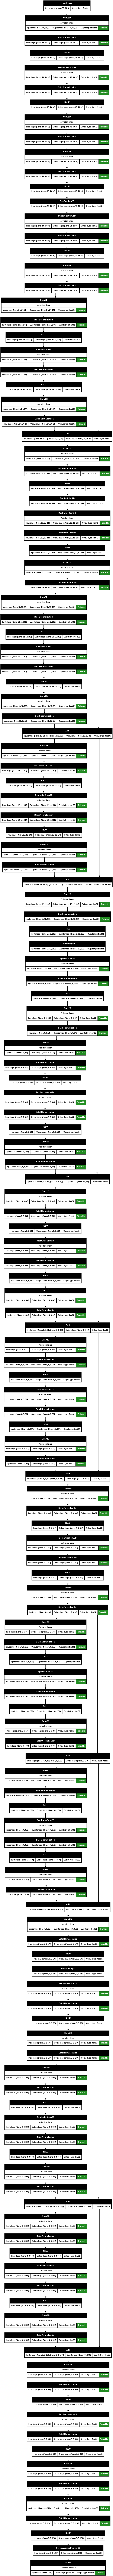

In [37]:
# View
tf.keras.utils.plot_model(
    model,
    to_file="MobileNetV2_w_added.png",
    # to_file="model_plots/MobileNetV2_w_added.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
    show_trainable=True,
    dpi=60)

In [38]:
# Freeze all of the weights of the pretrained layers
base_model.trainable = False

In [39]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: input_layer_1, Trainable: False
Layer: Conv1, Trainable: False
Layer: bn_Conv1, Trainable: False
Layer: Conv1_relu, Trainable: False
Layer: expanded_conv_depthwise, Trainable: False
Layer: expanded_conv_depthwise_BN, Trainable: False
Layer: expanded_conv_depthwise_relu, Trainable: False
Layer: expanded_conv_project, Trainable: False
Layer: expanded_conv_project_BN, Trainable: False
Layer: block_1_expand, Trainable: False
Layer: block_1_expand_BN, Trainable: False
Layer: block_1_expand_relu, Trainable: False
Layer: block_1_pad, Trainable: False
Layer: block_1_depthwise, Trainable: False
Layer: block_1_depthwise_BN, Trainable: False
Layer: block_1_depthwise_relu, Trainable: False
Layer: block_1_project, Trainable: False
Layer: block_1_project_BN, Trainable: False
Layer: block_2_expand, Trainable: False
Layer: block_2_expand_BN, Trainable: False
Layer: block_2_expand_relu, Trainable: False
Layer: block_2_depthwise, Trainable: False
Layer: block_2_depthwise_BN, Trainable: False
Laye

## Warm the model up

Task
+ Train teh model for a few epochs while keeping the base model weights fixed
+ This is in order to warm up the weights and biases in the top layers
+ Use a common learning rate rather than performing hyperparameter tuning
  Tuning lr is not to important in the first training as it might have limited impact since the base layers are frozen and the top layers are too few compared to the rest of the model
+ Monitor the validation accuracy ----- Stalling model or overfitting. decrease learning rate. Underfitting. increase slightly

In [40]:
ecb = tf.keras.callbacks.EarlyStopping(patience=5)

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9,
                                     beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [42]:
history = model.fit(train_set, validation_data=val_set, epochs=15, callbacks=[ecb])

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.7342 - loss: 11.9160 - val_accuracy: 0.7750 - val_loss: 15.8415
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.8159 - loss: 12.1346 - val_accuracy: 0.8086 - val_loss: 14.5788
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8342 - loss: 12.0494 - val_accuracy: 0.8184 - val_loss: 16.7337
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8425 - loss: 11.6516 - val_accuracy: 0.8103 - val_loss: 16.9418
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.8507 - loss: 11.6516 - val_accuracy: 0.8329 - val_loss: 15.2631
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8502 - loss: 11.9315 - val_accuracy: 0.8159 - val_loss: 18.8814
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.8592 - loss: 11.2471 - val_accuracy: 0.8238 - val_loss: 18.1688


Now the top layers are not too bad.  
+ Let's make the top part of the base mode trainable again.
+ Tune the learning rate
+ Utilize learning rate scheduling

In [43]:
# len(model.layers)

In [44]:
for layer in base_model.layers[-11:]:
    layer.trainable = True

In [45]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: input_layer_1, Trainable: False
Layer: Conv1, Trainable: False
Layer: bn_Conv1, Trainable: False
Layer: Conv1_relu, Trainable: False
Layer: expanded_conv_depthwise, Trainable: False
Layer: expanded_conv_depthwise_BN, Trainable: False
Layer: expanded_conv_depthwise_relu, Trainable: False
Layer: expanded_conv_project, Trainable: False
Layer: expanded_conv_project_BN, Trainable: False
Layer: block_1_expand, Trainable: False
Layer: block_1_expand_BN, Trainable: False
Layer: block_1_expand_relu, Trainable: False
Layer: block_1_pad, Trainable: False
Layer: block_1_depthwise, Trainable: False
Layer: block_1_depthwise_BN, Trainable: False
Layer: block_1_depthwise_relu, Trainable: False
Layer: block_1_project, Trainable: False
Layer: block_1_project_BN, Trainable: False
Layer: block_2_expand, Trainable: False
Layer: block_2_expand_BN, Trainable: False
Layer: block_2_expand_relu, Trainable: False
Layer: block_2_depthwise, Trainable: False
Layer: block_2_depthwise_BN, Trainable: False
Laye

## Hyperparameter tuning

Tune learning schedule hyperparameters

In [46]:
import keras_tuner as kt

In [50]:
def build_model(hp):
    lr = hp.Choice("learning_rate", values=[0.3, 0.1, 0.01, 0.003, 0.001, 0.0001])
    #  --- the best is 0.003 after 3 trials. training is costly and slow

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr,
        beta_1=0.9, beta_2=0.999
    )

    model_clone = tf.keras.models.clone_model(model)
    model_clone.set_weights(model.get_weights())

    model_clone.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer, metrics=["accuracy"])

    return model_clone

In [51]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="kt_parameter_tuning", project_name="random_search", seed=42)

In [52]:
random_search_tuner.search(train_set, epochs=10,
                           validation_data=val_set)

Trial 2 Complete [00h 05m 46s]
val_accuracy: 0.7129999995231628

Best val_accuracy So Far: 0.8644000291824341
Total elapsed time: 00h 10m 53s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.01              |0.003             |learning_rate

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - accuracy: 0.6739 - loss: 29.6741 - val_accuracy: 0.8102 - val_loss: 2.3848
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.7982 - loss: 1.3794 - val_accuracy: 0.8065 - val_loss: 1.8970
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.8273 - loss: 0.8616 - val_accuracy: 0.8018 - val_loss: 1.1480
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.8400 - loss: 0.8008 - val_accuracy: 0.8021 - val_loss: 1.1191
Epoch 5/10
 915/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8246 - loss: 0.9170

KeyboardInterrupt: 

In [53]:
best_trials = random_search_tuner.oracle.get_best_trials(num_trials=5)

In [54]:
for model in best_trials:
  print(model.summary())

Trial 0 summary
Hyperparameters:
learning_rate: 0.003
Score: 0.8644000291824341
None
Trial 1 summary
Hyperparameters:
learning_rate: 0.3
Score: 0.7129999995231628
None
Trial 2 summary
Hyperparameters:
learning_rate: 0.01
None


## Training

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9,
                                     beta_2=0.999)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
ecb = tf.keras.callbacks.EarlyStopping(patience=20)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer, metrics=["accuracy"])

In [47]:
history = model.fit(train_set, validation_data=val_set, callbacks=[ecb, lr_scheduler], epochs=100)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.7286 - loss: 33.6867 - val_accuracy: 0.7911 - val_loss: 5.2535 - learning_rate: 0.0030
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8149 - loss: 1.3479 - val_accuracy: 0.8383 - val_loss: 0.9562 - learning_rate: 0.0030
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.8389 - loss: 0.7815 - val_accuracy: 0.8115 - val_loss: 0.8862 - learning_rate: 0.0030
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8566 - loss: 0.6333 - val_accuracy: 0.8121 - val_loss: 0.8555 - learning_rate: 0.0030
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8630 - loss: 0.5680 - val_accuracy: 0.7969 - val_loss: 1.1764 - learning_rate: 0.0030
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8666 - loss: 0.5425 - val_accuracy: 0.8160 - val_loss: 1.1638 - learning_rate: 0.0030
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step 

In [55]:
model.save("cifar_tl_model.keras")

# Evaluation

In [56]:
saved_model = tf.keras.models.load_model("cifar_tl_model.keras")

In [57]:
batch_size = 10

In [58]:
loss, acc = saved_model.evaluate(val_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9036 - loss: 0.5734


In [59]:
true_class_names = []
predicted_class_names = []

# Get the  predictions and their original class_names
for image, label in val_set:
    # Get pred probas
    pred= saved_model.predict(image)
    # convert them to actual classes
    predicted_class_names.extend(pred.argmax(axis=1))
    # get the true label
    true_class_names.extend(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

In [60]:
np_true_class_names = np.array(true_class_names)
np_true_class_names[:10]

array([2, 7, 1, 9, 6, 8, 8, 2, 2, 7], dtype=uint8)

In [61]:
np_predicted_class_names = np.array(predicted_class_names)
np_predicted_class_names[:10]

array([2, 7, 1, 9, 6, 0, 8, 2, 2, 7])

In [62]:
misclassified = np.flatnonzero(np_true_class_names != np_predicted_class_names)
# how many
print(len(misclassified))
# View 10
misclassified[:10]

1018


array([  5,  20,  23,  34,  41,  49,  69,  82, 115, 125])

In [63]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay

In [66]:
ConfusionMatrixDisplay.from_predictions(
    y_true = true_class_names,
    y_pred = predicted_class_names,
    # display_class_names=class_names,
    xticks_rotation="vertical"
);

TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.

# Predictions with Gradio

In [ ]:
def image_pred(image, crop_to_aspect_ratio=True):
    # convert the image to a numpy array
    image = np.array(image)

    # Add an axis. To represent batch size. Models are trained with an extra axis at the front to represent batch size
    image = image[np.newaxis, ...]

    # resize the image
    resize = tf.keras.layers.Resizing(
        height=224,
        width=224,
        crop_to_aspect_ratio=crop_to_aspect_ratio
    )
    res_img = resize(image)

    # preprocess the image
    prep_img = tf.keras.applications.mobilenet.preprocess_input(res_img)

    # pred_probas
    pred_probas = saved_model.predict(prep_img)
    # Get the value of the max predicion probability
    max_pred_proba = np.max(pred_probas)
    # get the ineex of the max prediction probability
    pred = np.argmax(pred_probas, axis=1)
    # label
    label = class_names[pred[0]]

    # Convert the transformed image to an array
    res_array = np.array(res_img)
    # remove the first axis that was added above
    squeeze = np.squeeze(res_array, axis=0)
    # divide by max value
    plot_image = squeeze/250
    # clip
    clip = np.clip(plot_image, 0, 1)

    return clip, f"{label} {max_pred_proba}%"

In [ ]:
# from PIL import Image

# image_path = "sample_image/ss.jpg"
# image = Image.open(image_path)

# # Convert  to np array
# image_array = np.array(image)

# image_array.shape

In [ ]:
# t, u = image_pred(image_array)
# t

In [ ]:
import gradio as gr

In [ ]:
# Create the Gradio interface
interface = gr.Interface(
    fn=image_pred,
    inputs=[
        gr.Image(value="Image", type="numpy"),
        gr.Checkbox(label="Crop to aspect ratio")
    ],
    outputs=[
        gr.Image(value="Image", type="numpy", height=250, width=250),
        gr.Text(label="Prediction"),
    ],
    title="MobileNet 50 pretrained model. Trained on Flower dataset",
    description="""
    Predict 5 species of flower
    """
)

# Run the Gradio interface
interface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
